# Fractals and Chaos

In [1]:
# Settings and imports.
%matplotlib inline
from collections import Counter, OrderedDict, defaultdict
from functools import partial
from itertools import count, combinations
from math import sqrt, pi, sin, cos, atan, radians, degrees
from random import random, choice
from time import time
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image, ImageDraw, ImageColor
import seaborn as sns

from drawing import VectorImage, Turtle, show_image

-----

# A) Chaos Game

TODO: various improvements

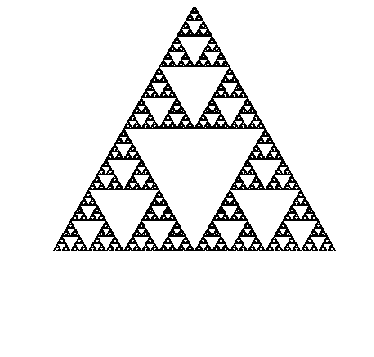

In [3]:
BLACK = (0, 0, 0)

def chaos_game(n_vertices=3, r=0.5, drop_first=100,
               size=400, n_iter=int(1e6)):
    im = Image.new('RGB', (size, size), color='white')
    angles = [
        radians(90 + i * 360/n_vertices)
        for i in range(n_vertices)]
    vertices = [
        (size/2 + cos(angle)*size/2, size/2 + sin(angle)*size/2)
        for angle in angles]
    x, y = random() * size, random() * size
    for i in range(n_iter):
        vertex = choice(vertices)
        x = x * r + vertex[0] * (1-r)
        y = y * r + vertex[1] * (1-r)
        if i > drop_first:
            im.putpixel((int(x), int(y)), BLACK)
    return im

im = chaos_game(n_vertices=3, r=0.5)
show_image(im, flipy=True)

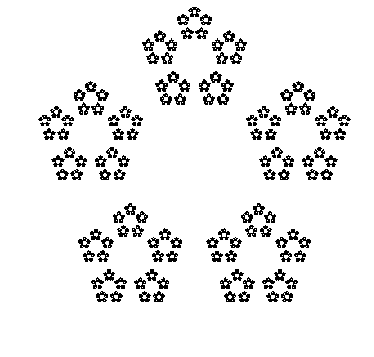

In [4]:
im = chaos_game(n_vertices=5, r=1/3)
show_image(im, flipy=True)

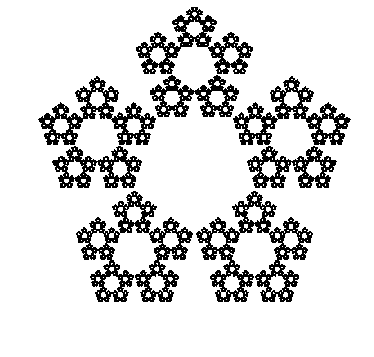

In [5]:
im = chaos_game(n_vertices=5, r=3/8)
show_image(im, flipy=True)

-----

# B) Feigenbaum Diagram

TODO: make it look better in the notebook

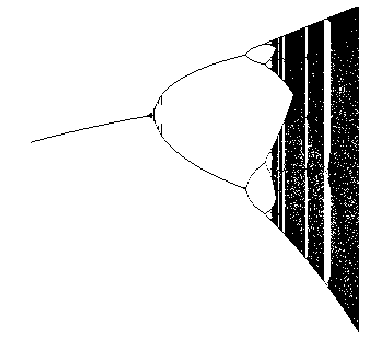

In [44]:
def feigenbaum(r_min=0.6, r_max=1.0, x_min=0, x_max=1,
               size=300, drop_first=100, n_iter=1000):
    im = Image.new('RGB', (size, size), color='white')
    r_step = (r_max - r_min) / size
    rs = [r_min + r_step*i for i in range(size)]
    x_step = (x_max - x_min) / size
    xs = [x_min + x_step*i for i in range(size)]
    for ix, r in enumerate(rs):
        x = x_min + random() * (x_max - x_min)
        for i_iter in range(n_iter):
            x = 4 * r * x * (1 - x)
            if i_iter > drop_first:
                iy = int(size * (x - x_min) / (x_max - x_min))
                im.putpixel((ix, iy), BLACK)
    return im

im = feigenbaum()
show_image(im, flipy=True)
im.save('feigenbaum.png')

-----

# C) L-Systems

TODO

- LSystem(axiom, rules, interpretation)
- `koch = LSystem.draw(n=4)`
- rules: [('F', 'F+F...'), ...]
- interpretation: {'F': 'forward(10)', ...}
- careful paralel replacement (generator expression)